In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
from itertools import count
from models.unet import unet
from settings import s
import time
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import dataloader
import json
from skimage import color
import matplotlib.pyplot as plt
from matplotlib import path
from color_discretizer import *

In [3]:
im=plt.imread('places-small/Places365_val_00000417.jpg')/255
im = trainset.data[12]/255
lab=color.rgb2yuv(im)
L=lab[:,:,:1]
Lten=torch.from_numpy(L.transpose((2,0,1))).unsqueeze(0)
abten=torch.from_numpy(lab[:,:,1:]).unsqueeze(0)

In [2]:
trainset = datasets.CIFAR10(root='./cifar-10', train=True,
                                    download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [5]:
AB=[]

In [6]:
from tqdm import tqdm
#histogram for color rarity
#hist=dict(enumerate(np.zeros(len(bins))))
for i in tqdm(range(1,500)):
    #image=trainloader.dataset.data[i]
    try:
        image=plt.imread('places-test/Places365_val_%08d.jpg'%i)/255
        #image=trainset.data[i]/255
    except FileNotFoundError:
        continue
    labim=color.rgb2lab(image)
    AB.extend(labim[:,:,1:].reshape(-1,2).tolist())
    #used_bins=dist_mat(bins,labim[:,:,1:].reshape(-1,2)).argmin(0)
    #for j in range(len(used_bins)):
    #    hist[used_bins[j]]+=1


100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [00:29<00:00, 16.94it/s]


In [7]:
for i in tqdm(range(20000)):
    #image=trainloader.dataset.data[i]
    try:
        #image=plt.imread('places-test/Places365_val_%08d.jpg'%i)/255
        image=trainset.data[i]/255
    except FileNotFoundError:
        continue
    labim=color.rgb2lab(image)
    AB.extend(labim[:,:,1:].reshape(-1,2).tolist())
    #used_bins=dist_mat(bins,labim[:,:,1:].reshape(-1,2)).argmin(0)
    #for j in range(len(used_b

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:15<00:00, 1329.71it/s]


In [8]:
ab=np.array(AB)

In [9]:
ab.shape

(53051392, 2)

In [10]:
bincount=22
H,xe,ye=np.histogram2d(ab[:,0],ab[:,1],bincount)

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


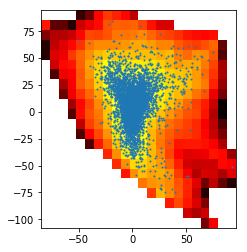

In [11]:
plt.imshow(np.rot90(np.log(H)),extent=(xe.min(),xe.max(),ye.min(),ye.max()),cmap='hot')
plt.scatter(*ab[np.random.permutation(len(ab))][:6000].T,s=1)


In [53]:
numbin=150
Hpr=np.zeros_like(H)
thres=np.sort(H.flatten())[::-1][numbin]
Hpr[H>thres]=H[H>thres]

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


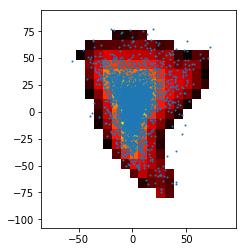

In [54]:
plt.imshow(np.rot90(np.log(Hpr)),extent=(xe.min(),xe.max(),ye.min(),ye.max()),cmap='hot')
plt.scatter(*ab[np.random.permutation(len(ab))][:6000].T,s=1)


In [55]:
binsize=np.array([np.gradient(xe).mean(),np.gradient(ye).mean()])
binsize

array([8.24422678, 9.19706466])

In [56]:
def ind2ab(ind):
    x0=np.array([xe[0],ye[0]])
    return x0+ind*binsize#+binsize/2

In [57]:
x=np.arange(0,bincount)
coord=np.vstack(map(np.ravel, np.meshgrid(x,x))).T

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [59]:
Habfull=ind2ab(coord).reshape(bincount,bincount,2)
Hab=np.zeros_like(Habfull)
Hab[H>thres]=Habfull[H>thres]
bins=Hab[Hab!=np.zeros(2)].reshape(-1,2)

In [60]:
torch.save(torch.from_numpy(bins),'resources/lab_bins.pt')

In [61]:
vflag=H>thres
np.save('resources/labhistogram.npy',H[vflag])

In [62]:
H.shape,x.shape,vflag.shape

((22, 22), (22,), (22, 22))

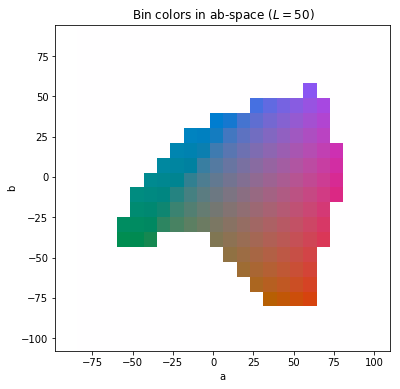

In [77]:
from skimage.transform import pyramid_expand
plt.figure(figsize=(6,6))
L=np.ones((len(x),len(x),1))*50
labspace=np.concatenate((L,Hab),axis=2)#.transpose(2,1,0)

labspace_w=np.ones_like(labspace)*np.array([100,0,0]).reshape(1,1,3)
labspace_w[vflag.reshape(len(x),len(x))]=labspace[vflag.reshape(len(x),len(x))]
rgbrep=color.lab2rgb(labspace_w)
#rgbrep=np.flipud(rgbrep)
#rgbrep=np.rot90(rgbrep,-1);rgbrep=np.fliplr(rgbrep)
#rgbrep=color.lab2rgb(pyramid_expand(labspace_w,(),0,0))
#rgbrep[rgbrep==np.zeros(3)]=np.ones_like(np.count_nonzero(rgbrep==np.zeros(3)))
plt.imshow(rgbrep,extent=(xe.min(),xe.max(),ye.min(),ye.max()))
#plt.imshow(rgbrep,extent=[-labspace.shape[1]*binsize/2, labspace.shape[1]*binsize/2, -labspace.shape[0]*binsize/2, labspace.shape[0]*binsize/2 ])
#plt.plot(labspecfromxyz[:,1]+127,127+labspecfromxyz[:,2],color='k',lw=1)
#plt.plot(labspec[:,1],-labspec[:,2],color='k',lw=1)
plt.axis('equal')
#plt.gca().grid(which='minor', color='w', linestyle='-', linewidth=2)
plt.xlabel('a')
plt.ylabel('b')
plt.title('Bin colors in ab-space $(L=%i)$'%L.flatten()[0])
#plt.savefig('figures/labgamut-bins.pdf')
bins=labspace[vflag.reshape(len(x),len(x))][:,1:]
for i in range(len(bins)):
    ...#plt.text(bins[i][0],bins[i][1],i)
#plt.scatter(*bins.T)
plt.savefig('figures/bincolors.pdf')
plt.show()

In [100]:
def distanceSquaredMatrix(A,B):
    return np.sum(np.square(A[:,None]-B),axis=2)
def K(X1,X2,sig=5):
    dist=distanceSquaredMatrix(X1,X2)
    kernel=np.zeros(dist.shape)
    cutoff=2*sig*np.log(10) #0 when kernel function would be smaller than 0.01
    kernel[dist<cutoff]=np.exp(-dist[dist<cutoff]/(2*sig))
    return kernel

In [105]:
soft=(K(bins,bins,30))

In [109]:
torch.save(torch.from_numpy(soft),'resources/smooth_onehot150.pt')